# 环境变量

In [2]:
output_dir='./output_zero/'
faiss_path=output_dir+'faiss_index'

novel_chunk_dir=output_dir+'novel_chunks/'
distilled_log_dir=output_dir+'distilled_log/'
chapter_summary_dir=output_dir+'chapter_summary/'
merged_log_path=output_dir+'merged_log.json'
rename_map_path=output_dir+'rename_map.json'
all_chapters_path=output_dir+'all_chapters.json'



bg_hint_len=500
retrospect_len=100
summary_chunk_len=500 # shouldn't be too large. because chatgpt's summary is very short. need to fine-tune this number
summary_chunk_overlap=0
final_summary_chunk_len=1300

import os, json
rename_map=json.load(open(rename_map_path,'r',encoding='utf-8')) if os.path.exists(rename_map_path) else {}

if not os.path.exists(chapter_summary_dir):
    os.makedirs(chapter_summary_dir)

# 加载llm

In [3]:
from my_llm import llm_chatgpt as llm
llm('你好')

c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:165: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:676: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


你好你好！有什么我可以帮助你的吗？


'你好！有什么我可以帮助你的吗？'

# 加载FAISS背景知识索引

In [4]:
import importlib,my_faiss;importlib.reload(my_faiss)
from my_faiss import FAISS,embeddings,get_bg_hint
get_bg_hint.vector_store=FAISS.load_local(faiss_path, embeddings)
get_bg_hint('露易丝')

No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.


'【露易丝 露易丝·法兰西斯·露·布朗·杜·拉·瓦利埃尔 本作女主角，作品中一般称为露易丝，有着夹杂金色的粉红长卷发、茶褐色的眼瞳（动画为桃红色）。】\n【露易丝 起初对身为贵族的身份有着很强的自觉心，拥有常人N倍的自尊心，后来受才人影响，逐渐放下这份执着，转而为才人着想。在后期已经可以对才人敞开心扉，坦诚相待。】\n【露易丝 动画第三期中为救出塔芭莎而放弃贵族身份，但被公主赏识，成为王位继承人。喜欢平贺才人。】\n【平贺才人 已与露易丝同居中。同时被书中许多女性角色爱慕著。喜欢露易丝。】\n【露易丝 的性格易怒，容易骂人，有点糊涂（跟才人比），为了小事常常生气。】\n【露易丝 在托里斯汀东北拥有领土的名门拉·瓦利埃尔公爵家的三女儿、托里斯汀魔法学院的二年级学生。】\n【安丽埃塔 小说16-17卷有欲从露易丝那里里夺取才人，羡慕著露易丝。】\n【露易丝 为露易丝配音的钉宫理惠，亦是J.C. STAFF前一部作品《灼眼的夏娜》中夏娜的声优。同时也是傲娇的著名角色之一，钉宫四萌之一】\n【平贺才人 亚成婚，后与露易丝回到自己所属的世界，回到自己家中。】'

# 处理gpt返回的json

In [18]:
import json,random
from glob import glob
import os
from tqdm.auto import tqdm


# # separate info, act into individual items
def purge_content(all_content):
    for item in all_content:
        if 'info' in item:
            info_str=item['info']
            if 'expression' in item:
                info_str=item['expression']+' '+info_str
            if 'char' in item:
                info_str=item['char']+' '+info_str
            yield {'info':info_str,'src_id':item['src_id']}
        if 'char' in item:
            base_info={'char':item['char'],'src_id':item['src_id']}
            if 'expression' in item:
                base_info['expression']=item['expression']
            if 'act' in item:
                yield {**base_info,'act':item['act']}
            else:
                if 'think' in item:
                    base_info['think']=item['think']
                if 'say' in item:
                    base_info['say']=item['say']
                if 'think' in item or 'say' in item:
                    yield base_info

def reload_chunks(slient=False):
    global chunks,all_content
    chunks={}
    for path in glob(os.path.join(novel_chunk_dir,'CHUNK*.json')):
        with open(path) as f:
            chunk=json.load(f)
            chunks[chunk['id']]=chunk
    for path in glob(os.path.join(distilled_log_dir,'RESPONSE*.json')):
        with open(path) as f:
            chunk=json.load(f)
            if 'content' in chunk and chunk['content']:
                for item in chunk['content']:
                    item['src_id']=chunk['id']
            chunks[chunk['id']]=chunk
    if not slient:print('load chunks:',len(chunks))
    if not slient:print('num of distilled chunks:',len([chunk for chunk in chunks.values() if 'content' in chunk]))

    chunks=dict(sorted(chunks.items(), key=lambda item: item[0]))

    all_content=[item for chunk in chunks.values() if 'content' in chunk and chunk['content'] for item in chunk['content']]
    all_content=list(purge_content(all_content))
    all_content[:10]
    if not slient:print('Total items:', len(all_content))
    json.dump(all_content, open(merged_log_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
    print('save merged log to',merged_log_path)

reload_chunks()

load chunks: 2333
num of distilled chunks: 1796
Total items: 26187
save merged log to ./output_zero/merged_log.json


### 统计角色出现的频率，统一名字中的同音字

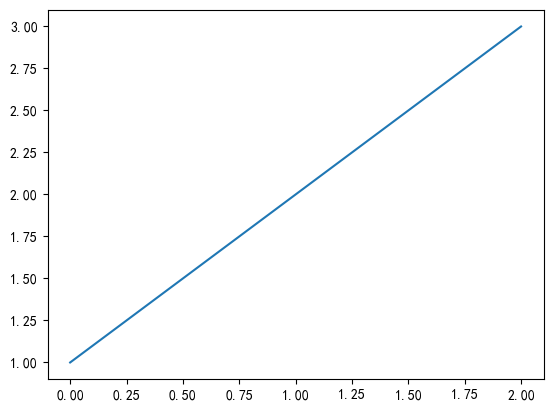

In [19]:
# run this block to avoid crash when loading chinese font in matplotlib
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.figure()
plt.plot([1,2,3])
plt.show()


load, update and save rename_map at path: ./output_zero/rename_map.json


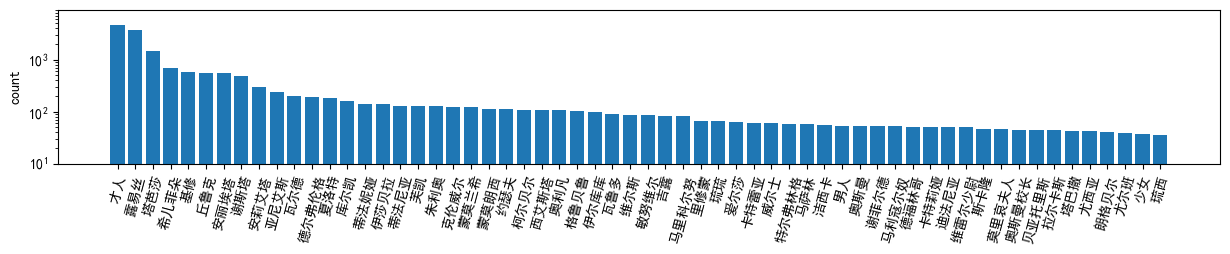

list of characters and their frequencies: {'才人': 4509, '露易丝': 3747, '塔芭莎': 1439, '希儿菲朵': 693, '基修': 588, '丘鲁克': 555, '安丽埃塔': 542, '谢斯塔': 481, '安莉艾塔': 294, '亚尼艾斯': 237, '瓦尔德': 202, '德尔弗伦格': 192, '夏洛特': 180, '库尔凯': 160, '蒂法妮娅': 143, '伊莎贝拉': 142, '蒂法尼亚': 130, '芙凯': 128, '朱利奥': 127, '克伦威尔': 123, '蒙莫兰希': 123, '蒙莫朗西': 114, '约瑟夫': 113, '柯尔贝尔': 110, '西艾斯塔': 110, '奥利凡': 107, '格鲁贝鲁': 103, '伊尔库库': 100, '瓦鲁多': 92, '维尔斯': 87, '敏努维尔': 87, '吉露': 82, '马里科尔努': 81, '里修蒙': 67, '琉琉': 66, '爱尔莎': 64, '卡特蕾亚': 62, '威尔士': 60, '特尔弗林格': 59, '马萨林': 57, '洁西卡': 55, '男人': 54, '奥斯曼': 54, '谢菲尔德': 54, '马利寇尔奴': 53, '德福林哥': 51, '卡特莉娅': 51, '迪法尼亚': 51, '维雷尔少尉': 50, '斯卡隆': 47, '莫里哀夫人': 46, '奥斯曼校长': 45, '贝亚托里斯': 45, '拉尔卡斯': 44, '塔巴撒': 43, '尤西亚': 42, '朗格贝尔': 40, '尤尔班': 39, '少女': 38, '琉西': 36, '学生们': 35, '贝塔夏尔': 35, '托马斯': 34, '村民们': 33, '吉尔摩阿': 33, '霍金斯将军': 33, '士兵': 32, '德?罗雷努': 32, '公爵': 31, '雅妮特': 30, '店主': 30, '尼可拉': 30, '阿妮艾斯': 30, '约瑟夫国王': 29, '侍女': 28, '卢涅': 27, '水之精灵': 26, '斯蒂克斯': 26, '艾伯特': 25, '谢弗勒兹': 25, '阿尼艾斯': 2

In [20]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

import os
rename_map=json.load(open(rename_map_path,'r',encoding='utf-8')) if os.path.exists(rename_map_path) else {}
rename_map_added={'塔巴萨':'塔芭莎','塔巴莎':'塔芭莎','雪丝塔':'谢斯塔','摩莫朗希':'蒙莫朗西','夏尔洛特':'夏洛特','希尔菲德':'希儿菲朵','西布鲁兹':'谢弗勒兹','谢丝塔':'谢斯塔','路易丝':'露易丝','琪尔可':'丘鲁克','芙卡':'芙凯','露易兹':'露易丝'}
rename_map.update(rename_map_added)
json.dump(rename_map, open(rename_map_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('load, update and save rename_map at path:', rename_map_path)

# we use the original name in history text, but the new name for labeling

char_freq={}
for item in all_content:
    if 'char' in item:
        char=rename_map.get(item['char'], item['char'])
        if char not in char_freq:
            char_freq[char]=0
        char_freq[char]+=1
char_freq={k: v for k, v in sorted(char_freq.items(), key=lambda item: item[1], reverse=True)}
selected_char=list(sorted(char_freq.keys(), key=lambda x: char_freq[x], reverse=True)[:9999])

def list_char_items(content, char):
    for item in content:
        if item.get('char', None) == char:
            print(item)


plt.figure(figsize=(15, 2))
plt.bar(list(char_freq.keys())[:60], list(char_freq.values())[:60])
plt.xticks(rotation=75)
plt.ylabel('count')
plt.yscale('log')
plt.ylim(10,np.max(list(char_freq.values()))*2)
plt.show()

print('list of characters and their frequencies:',char_freq)
print('rename_map:', rename_map)
print('selected_char:', selected_char)

# revising character name typo

def revise_name(obj):
    if isinstance(obj,str):
        for from_name,to_name in rename_map.items():
            obj=obj.replace(from_name,to_name)
        return obj,True
    else:
        return obj,False

def revise_json_object_recursive(obj,revise_func):
    obj,terminate=revise_func(obj)
    if not terminate:
        if isinstance(obj,dict):
            for key,value in obj.items():
                obj[key]=revise_json_object_recursive(value,revise_func)
        if isinstance(obj,list):
            for i in range(len(obj)):
                obj[i]=revise_json_object_recursive(obj[i],revise_func)
    return obj

def fix_names(slient=False):
    global chunks,all_content
    all_content=revise_json_object_recursive(all_content,revise_func=revise_name)
    chunks=revise_json_object_recursive(chunks,revise_func=revise_name)
    print('revise name done (not saved to original chunks)')
    json.dump(all_content, open(merged_log_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
    print('save merged_log_path:', merged_log_path)

# 将chunk合并成章节，并进行总结

In [21]:
from glob import glob

def reload_chapters(slient=False):
    global chapters
    chapters={}
    for chapter_summary_path in glob(os.path.join(chapter_summary_dir, f'CHAPTER*.json')):
        if not slient:print('load',chapter_summary_path)
        chapter_summary = json.load(open(chapter_summary_path, 'r', encoding='utf-8'))
        iChapter = int(chapter_summary_path.split('.')[-2].split('_')[-1])
        chapters[iChapter]=chapter_summary
    chapters={k: v for k, v in sorted(chapters.items(), key=lambda item: item[0])}
    if not slient:print('reload',len(chapters),'chapters')

def save_chapter(iChapter,chapter,slient=False):
    chapters[iChapter]=chapter
    json.dump(chapter, open(os.path.join(chapter_summary_dir, f'CHAPTER_{iChapter}.json'), 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
    if not slient: print('save chapter',iChapter,'to',os.path.join(chapter_summary_dir, f'CHAPTER_{iChapter}.json'))
    json.dump(chapters, open(os.path.join(all_chapters_path), 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
    

reload_chapters(slient=True)

def update_chapters_from_chunks(slient=False):
    global chapters, chunks

    for chapter in chapters.values():
        chapter['chunk_summaries']=[]
        chapter['chunk_ids']=[]
    for iChunk,chunk in tqdm(sorted(chunks.items())):
        chapter=chapters.get(int(chunk['chapter_id']), {}) 
        chapter['chapter_id']=chunk['chapter_id']
        chapter['title']=chunk['title']
        chapter['chunk_ids']=chapter.get('chunk_ids', [])+[chunk['id']]
        if 'summary' in chunk:
            chapter['chunk_summaries']=chapter.get('chunk_summaries', [])+[chunk['summary']]
        chapters[int(chunk['chapter_id'])]=chapter

    for iChapter,chapter in tqdm(chapters.items()):
        save_chapter(int(iChapter),chapter,slient=slient)
update_chapters_from_chunks(slient=True)


  0%|          | 0/2333 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

### 将chunk的summary和bg_hint合并，作为chapter的summary

In [22]:
from langchain.chains.base import Chain
import json
import re
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

class FurtherSummaryStoryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    refine_bg_hint:bool=True
    bg_hint_num:int=10
    bg_hint_len:int=400
    retrospect_len:int=100
    @property
    def input_keys(self):
        return ['text']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''
可能有关的背景材料
{background}
【前情提要：{retrospect}】
请去除下面情节梗概中重复的部分，请尽量不要丢掉信息。不要加入额外的推测，请忠实于原著。不要加入没有意思的套话。
{text}
精简后的情节梗概：'''
    def _call(self,inputs:dict)->dict:
        print('requesting summary')
        bghint_input=inputs.get('summary',inputs['text'])
        if self.get_bg_hint is not None:
            bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            bg_hint='（无）'
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=inputs.get('retrospect','(无)')[-self.retrospect_len:]
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[\s]*[\d]+[\.、][\s]*','',response)
        if self.refine_bg_hint and 'summary' not in inputs:
            print('refine the summary by using the bg hint genereated by the current summary')
            return self._call({**inputs,'summary':response})
        else:
            return {'summary':response}
    

class FinalSummaryStoryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    refine_bg_hint:bool=False
    bg_hint_num:int=10
    bg_hint_len:int=400
    retrospect_len:int=100
    @property
    def input_keys(self):
        return ['text']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''
可能有关的背景材料
{background}
【前情提要：{retrospect}】
请非常简要地概括下面的故事，字数限制在五十字以内，抓住重点，抓住关键的情节走向和可能对后文产生影响的重大细节。不要加入额外的推测，请忠实于原著。不要加入没有意思的套话。
{text}
精简后的情节梗概：'''
    def _call(self,inputs:dict)->dict:
        print('requesting summary')
        bghint_input=inputs.get('summary',inputs['text'])
        if self.get_bg_hint is not None:
            bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            bg_hint='（无）'
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=inputs.get('retrospect','(无)')[-self.retrospect_len:]
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[\s]*[\d]+[\.、][\s]*','',response)
        if self.refine_bg_hint and 'summary' not in inputs:
            print('refine the summary by using the bg hint genereated by the current summary')
            return self._call({**inputs,'summary':response})
        else:
            return {'summary':response}


further_summary_story_chain=FurtherSummaryStoryChain(llm=llm,get_bg_hint=get_bg_hint,
                                            bg_hint_len=bg_hint_len,retrospect_len=retrospect_len)
final_summary_story_chain=FinalSummaryStoryChain(llm=llm,get_bg_hint=get_bg_hint,
                                            bg_hint_len=bg_hint_len,retrospect_len=retrospect_len) 
text_splitter=RecursiveCharacterTextSplitter(chunk_size=summary_chunk_len,chunk_overlap=summary_chunk_overlap)

def further_summary_story(summaries,retrospect=None,final_summary_chunk_len=250):
    all_summary_text='\n'.join([summary.replace('\n','') for summary in summaries])
    retrospect=retrospect or '（无）'
    if len(all_summary_text)<=final_summary_chunk_len:
        print('length of all summaries is less than final_summary_chunk_len, no further summarizing')
        final_summary=final_summary_story_chain({'text':all_summary_text,'retrospect':retrospect})['summary']
        if len(summaries)==1:
            return [final_summary]
        else:
            return [final_summary,['\n'.join(summaries)]]
    else:
        print('further summarizing story, num of summaries at current level:',len(summaries), 'total length:',sum([len(summary) for summary in summaries]))
        text_chunks=text_splitter.split_text(all_summary_text)
        chunk_summaries=[]
        chunk_retrospect=''
        for text_chunk in text_chunks:
            all_retrospect=(retrospect+'。'+chunk_retrospect).replace('\w','')
            chunk_summary=further_summary_story_chain({'text':text_chunk,'retrospect':all_retrospect})['summary']
            chunk_retrospect=chunk_summary
            chunk_summaries.append(chunk_summary)
        cascades=further_summary_story(chunk_summaries,retrospect,final_summary_chunk_len=final_summary_chunk_len)
        return cascades+[chunk_summaries]

# llm.show_query=llm.show_response=True

# summaries=chapters[22]['chunk_summaries']
# # summaries=chapters[21]['chunk_summaries']+chapters[22]['chunk_summaries']+chapters[23]['chunk_summaries']
# summary_cascades=further_summary_story(summaries,final_summary_chunk_len=final_summary_chunk_len)
# print('final summary:',summary_cascades[0])
# print('semifinal summary:',summary_cascades[1])
# print('summary cascade:',summary_cascades)

# llm.show_query=llm.show_response=False

In [23]:
from my_chains import Text2JsonChain



class ExtractStoryElementsChain(Text2JsonChain):
    get_bg_hint:object=None
    bg_hint_num:int=10
    bg_hint_len:int=400
    summary_len:int=100
    retrospect_len:int=100
    story_summary_chain:object=None
    prompt='''可能有关的背景信息：（不要加入到回复中）
{background}
【前情提要：{retrospect}】
【本段概要：{summary}】
对下文中的主要角色，分条提取角色的目标动机goal，遇到的主要阻碍obstacle，所做出的行为与决策plan，以及角色在故事中起到的作用role。
只需要输出主要角色，按你认为的角色的重要性排序。
输出格式：{{
    "小明":{{
        "goal":"上街买菜",
        "obstacle":"没钱",
        "plan":"找人借钱",
        "role":"主角的朋友，负责买菜"
    }}
}}
确保json格式正确。
不加自己的推测想法，请忠实于原著，不要盲目正面。不要加入没有意思的套话。请修正可能被搞混淆的角色名字。
可能有关的背景信息：（不要加入到回复中）
文本：
{text}
json：'''
    @property
    def output_keys(self):
        return super().output_keys+['summary','background','retrospect']
    def _call(self,inputs:dict)->dict:
        summary=self.story_summary_chain({**inputs,'summary':inputs['text']})['summary'] if self.story_summary_chain is not None and 'summary' not in inputs else inputs.get('summary','（无）')
        bg_hint_input=summary if 'summary' in inputs else inputs['text']
        bg_hint=self.get_bg_hint(bg_hint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len) if self.get_bg_hint is not None else '（无）'
        retrospect=inputs.get('retrospect','（无）')

        inputs['summary']=summary.replace('\n','').strip()[:self.summary_len]
        inputs['background']=bg_hint.strip()[-self.bg_hint_len:]
        inputs['retrospect']=retrospect.replace('\n','').strip()[-self.retrospect_len:]

        print('requesting ExtractStoryElementsChain')
        outputs=super()._call(inputs)
        outputs['summary']=summary.replace('\n','')
        outputs['background']=bg_hint
        outputs['retrospect']=retrospect.replace('\n','')
        return outputs
    
extract_story_elements_chain=ExtractStoryElementsChain(llm=llm,get_bg_hint=get_bg_hint,story_summary_chain=further_summary_story_chain,
                                            bg_hint_len=bg_hint_len,retrospect_len=retrospect_len)


# llm.show_query=llm.show_response=True
# story_elements=extract_story_elements_chain({'text':'\n'.join(summary_cascades[1]),'summary':summary_cascades[0]})
# llm.show_query=llm.show_response=False

### 一条一条提交给llm

In [24]:
reload_chunks(slient=True)
fix_names(slient=True)
reload_chapters(slient=True)
update_chapters_from_chunks(slient=True)
llm.show_query=llm.show_response=False

failed_iChapters_this_run=set()
import time

while True:
    # sleep .5 s
    time.sleep(.5)
    # reload_chunks(slient=True)
    # fix_names()
    reload_chapters(slient=True)
    # update_chapters_from_chunks(slient=True)
    found=False
    for iChapter,chapter in chapters.items():
        if 'characters' in chapter and 'characters' in chapter:
            continue
        if iChapter in failed_iChapters_this_run:
            continue
        if 'chunk_summaries' not in chapter:
            continue
        if len(chapter['chunk_summaries'])!=len(chapter['chunk_ids']):
            continue
        found=True
        break
    if not found:
        break
    try:
        print('processing chapter',iChapter,chapter['title'])
        retrospect=chapters[iChapter-1]['summary'] if iChapter-1 in chapters and 'summary' in chapters[iChapter-1] else '（无）'
        if 'summary_cascades' not in chapter:
            chapter['summary_cascades']=further_summary_story(chapter['chunk_summaries'],final_summary_chunk_len=final_summary_chunk_len)
            chapter['summary']=chapter['summary_cascades'][0]
            save_chapter(iChapter,chapter)
        if 'characters' not in chapter:
            response=extract_story_elements_chain({'text':'\n'.join(chapter['summary_cascades'][1]),'summary':chapter['summary'],'retrospect':retrospect})
            if response['content'] is not None:
                chapter['characters']=response['content']
            else:
                print('story elements extraction failed')
                print(response['error'])
                chapter['characters_failed']=response['response']
                failed_iChapters_this_run.add(iChapter)
            save_chapter(iChapter,chapter)
    except Exception as e:
        failed_iChapters_this_run.add(iChapter)
        print(e)
        print('chapter',iChapter,'failed')
        continue
print('nothing to do')

save merged log to ./output_zero/merged_log.json
revise name done (not saved to original chunks)
save merged_log_path: ./output_zero/merged_log.json


  0%|          | 0/2333 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

processing chapter 20 后记
list index out of range
chapter 20 failed
processing chapter 61 第五卷 托里斯塔尼亚的假日 第二章
further summarizing story, num of summaries at current level: 20 total length: 2831
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
length of all summaries i

# Trash code after here

In [ ]:
assert False

In [ ]:
class FinalSummaryStoryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    bg_hint_num:int=10
    bg_hint_len:int=400
    retrospect_len:int=100
    @property
    def input_keys(self):
        return ['text','retrospect']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''
可能有关的背景材料
{background}
【前情提要：{retrospect}】
问：下面是一个完整的小说章节中不同段落的分段梗概，请用连贯的语言详述一下本小说章节。不要加入额外的推测，请忠实于原著，不要加入没有意思的概概而谈的套话。
{text}
答：'''
    def _call(self,inputs:dict)->dict:
        bghint_input=inputs['text']
        if self.get_bg_hint is not None:
            bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            bg_hint='（无）'
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=inputs['retrospect'][-self.retrospect_len:]
        query=self.prmopt.format(**inputs)
        print('requesting summary')
        response=self.llm(query)
        response=re.sub(r'[\s]*[\d]+[\.、][\s]*','',response)
        return {'summary':response}